In [1]:
import numpy as np
import sympy

import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from IPython.display import Markdown, display
import itertools
from IPython.display import Markdown, display,HTML,Image

from z3 import *

### Puzzle as published 
https://www.janestreet.com/puzzles/number-cross-index/

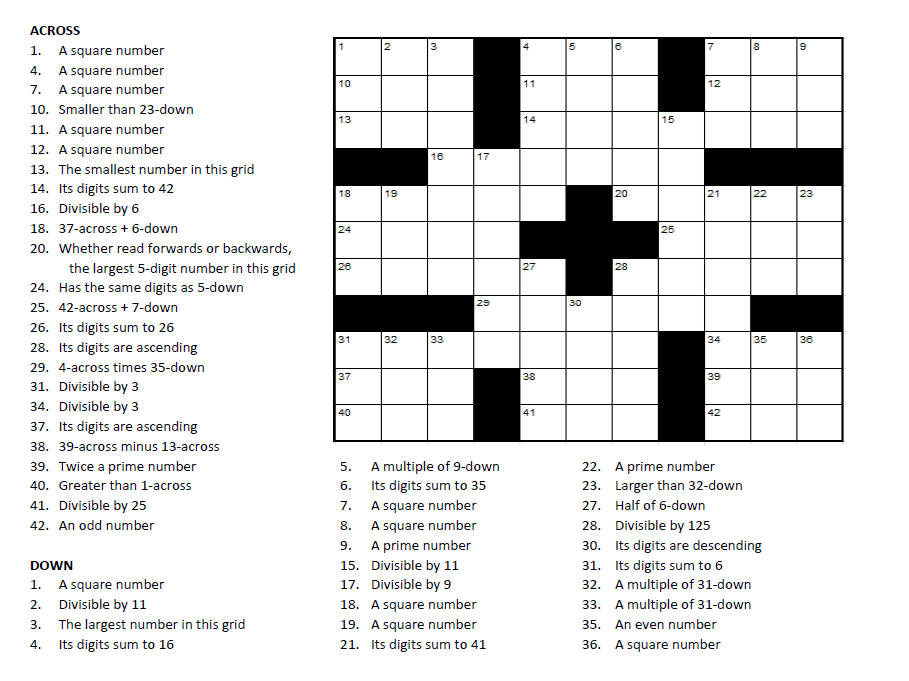

In [2]:
url='https://www.janestreet.com/puzzles/number-cross-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Puzzle as published \n'+url))
display(Image('https://www.janestreet.com/puzzles/number_crossword_with_clues.png',width=500))
HTML(str(soup.find_all('div', {'class' :'inner-wrapper'})[1]))

In [3]:
grid = np.array([[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
                 [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
                 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                 [1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1],
                 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                 [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
                 [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
                ],dtype=int)

In [4]:
# some utility functions
def mult(x):
    n=len(x)
    return Sum([x[i] *10**((n-1)-i)  for i in range(n)]) 

def sum_dig(x):
    return Sum([i for i in x])

def make_across(x,y,n):
    return [X[x][y+i] for i in range(n)]

def make_down(x,y,n):
    return [X[x+i][y] for i in range(n)]

**Solution 407,358 found after 2.7925 seconds**

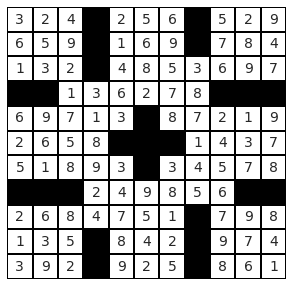

In [10]:
start = time.time()

# Setup # 11x11 matrix of integer variables and solver 
X = np.array(IntVector("x",11*11),dtype=object).reshape((11,11))
s = Tactic("pqffd").solver()

# each non-black cell contains a value in {1, ..., 9} black cells = 0
s += [And(e>0,e<=9) if grid[i,j] !=1 else e==0 for (i,j),e in np.ndenumerate(X)]

# Set up the clues 
across = {}
across[1]  = make_across(0,0,3)
across[4]  = make_across(0,4,3)
across[7]  = make_across(0,8,3)
across[10] = make_across(1,0,3)
across[11] = make_across(1,4,3)
across[12] = make_across(1,8,3)
across[13] = make_across(2,0,3)
across[14] = make_across(2,4,7)
across[16] = make_across(3,2,6)
across[18] = make_across(4,0,5)
across[20] = make_across(4,6,5)
across[24] = make_across(5,0,4)
across[25] = make_across(5,7,4)
across[26] = make_across(6,0,5)
across[28] = make_across(6,6,5)
across[29] = make_across(7,3,6)
across[31] = make_across(8,0,7)
across[34] = make_across(8,8,3)
across[37] = make_across(9,0,3)
across[38] = make_across(9,4,3)
across[39] = make_across(9,8,3)
across[40] = make_across(10,0,3)
across[41] = make_across(10,4,3)
across[42] = make_across(10,8,3)

down = {}
down[1] = make_down(0,0,3)
down[2] = make_down(0,1,3)
down[3] = make_down(0,2,7)
down[4] = make_down(0,4,5)
down[5] = make_down(0,5,4)
down[6] = make_down(0,6,5)
down[7] = make_down(0,8,3)
down[8] = make_down(0,9,3)
down[9] = make_down(0,10,3)
down[15] = make_down(2,7,6)
down[17] = make_down(3,3,6)
down[18] = make_down(4,0,3)
down[19] = make_down(4,1,3)
down[21] = make_down(4,8,7)
down[22] = make_down(4,9,3)
down[23] = make_down(4,10,3)
down[27] = make_down(6,4,5)
down[28] = make_down(6,6,5)
down[30] = make_down(7,5,4)
down[31] = make_down(8,0,3)
down[32] = make_down(8,1,3)
down[33] = make_down(8,2,3)
down[35] = make_down(8,9,3)
down[36] = make_down(8,10,3)

clues =[v for k,v in across.items()]+[v for k,v in down.items()]

# distinct clues and letters in clues
s += Distinct([mult(i) for i in clues])
s += [Distinct([x for x in i]) for i in clues]

# The clues 

#squares
square_numbers = [i**2 for i in range(10,32)]
sq_across = [1,4,7,11,12]
s += [Or([mult(across[i]) == x for x in square_numbers]) for i in sq_across]
sq_down = [1,7,8,18,19,36]
s += [Or([mult(down[i]) == x for x in square_numbers]) for i in sq_down]

#primes
prime_numbers = [*sympy.primerange(100,1000)]
pr_across = [39]
s += [Or([mult(across[i]) == x*2 for x in prime_numbers]) for i in pr_across]
pr_down = [9,22]
s += [Or([mult(down[i]) == x for x in prime_numbers]) for i in pr_down]

# simple across
s += mult(across[10]) < mult(down[23])
s += And([mult(across[13]) <= mult(i) for i in clues])
s += sum_dig(across[14]) ==42
s += mult(across[16]) % 6 ==0
s += mult(across[18]) == (mult(across[37])+mult(down[6]))
s += And([And(mult(across[20]) >= mult(i),mult(across[20][::-1]) > mult(i)) for i in clues if len(i) == 5])
s += Or([And([across[24][i]==j[i] for i in range(4)]) for j in itertools.permutations(down[5],4)])
s += And([across[28][i-1] < across[28][i] for i in range(1,len(across[28]))])
s += mult(across[25]) == (mult(across[42])+mult(down[7]))
s += sum_dig(across[26]) == 26
s += And([across[28][i-1] < across[28][i] for i in range(1,len(across[28]))])
s += mult(across[29]) == (mult(across[4])*mult(down[35]))
s += mult(across[31]) % 3 ==0
s += mult(across[34]) % 3 ==0
s += And([across[37][i-1] < across[37][i] for i in range(1,len(across[37]))])
s += mult(across[38]) == (mult(across[39])-mult(across[13]))
s += mult(across[40]) > mult(across[1])
s += mult(across[41]) % 25 ==0
s += mult(across[42]) %  2 ==1

# simple down
s += mult(down[2]) % 11 ==0
s += And([mult(down[3]) >= mult(i) for i in clues])
s += sum_dig(down[4]) == 16
s += Or([mult(down[5]) * i  == mult(down[9]) for i in range(1,10)]+[mult(down[5]) == mult(down[9])*i for i in range(1,10)])
s += sum_dig(down[6]) == 35
s += mult(down[15]) % 11 ==0
s += mult(down[17]) % 9 ==0
s += sum_dig(down[21]) == 41
s += mult(down[23]) > mult(down[32])
s += mult(down[27])*2 == mult(down[6])
s += mult(down[28]) % 125 ==0
s += And([down[30][i-1] > down[30][i] for i in range(1,len(down[30]))])
s += sum_dig(down[31]) == 6
s += Or([mult(down[32]) *i  == mult(down[31]) for i in range(1,10)]+[mult(down[32]) == mult(down[31])*i for i in range(1,10)])
s += Or([mult(down[33]) *i  == mult(down[31]) for i in range(1,10)]+[mult(down[33]) == mult(down[31])*i for i in range(1,10)])
s += mult(down[35]) % 2 ==0

# Solve and print 
if s.check() == sat:
    m = s.model()
    evalu = np.vectorize(lambda x:m.evaluate(x).as_long())
    r = evalu(X)
    display(Markdown("**Solution {:,.0f} found after {:.4f} seconds**".format(sum([mult(evalu(x)) for x in clues if len(x) ==5]),time.time()-start)))
    annot = r.astype('str')
    annot[annot=="0"] =""
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    ax =sns.heatmap(grid,annot=annot,cbar=False,cmap="Greys",fmt="",linewidths=2,annot_kws={"size":14},linecolor='k')
    ax.axis("off")
    plt.show()
else:
    print("Failed")  

### Puzzle as published 
https://www.janestreet.com/puzzles/number-cross-solution/

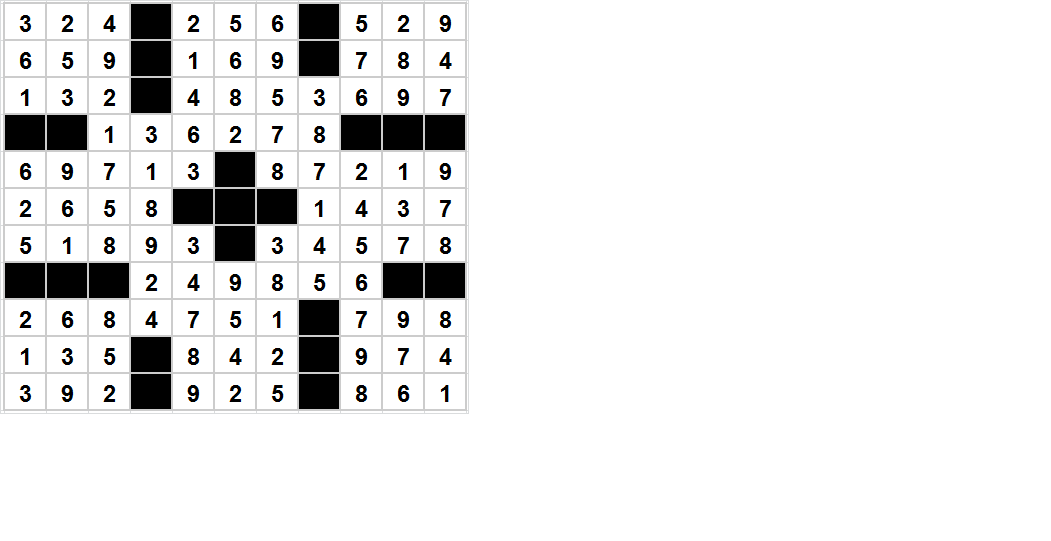

In [8]:
url='https://www.janestreet.com/puzzles/number-cross-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Puzzle as published \n'+url))
display(Image('https://www.janestreet.com/puzzles/Aug14_Solution.png',width=500))
HTML(str(soup.find_all('div', {'class' :'inner-wrapper'})[1]))

In [ ]:
solution = np.array([[3,2,4,0,2,5,6,0,5,2,9],
                     [6,5,9,0,1,6,9,0,7,8,4],
                     [1,3,2,0,4,8,5,3,6,9,7],
                     [0,0,1,3,6,2,7,8,0,0,0],
                     [6,9,7,1,3,0,8,7,2,1,9],
                     [2,6,5,8,0,0,0,1,4,3,7],
                     [5,1,8,9,3,0,3,4,5,7,8],
                     [0,0,0,2,4,9,8,5,6,0,0],
                     [2,6,8,4,7,5,1,0,7,9,8],                 
                     [1,3,5,0,8,4,2,0,9,7,4],
                     [3,9,2,0,9,2,5,0,8,6,1]
                    ],dtype=int)

